In [5]:
from openvino.runtime import Core
ie = Core()
print("使用Core()初始化推理引擎: {}".format(ie))

print("显示主机CPU/GPU设备信息。")
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device_name=device, property="FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")


使用Core()初始化推理引擎: <Core: available plugins[CPU, GPU.0, GPU.1]>
显示主机CPU/GPU设备信息。
CPU: 13th Gen Intel(R) Core(TM) i9-13900HX
GPU.0: Intel(R) RaptorLake-S Mobile Graphics Controller (iGPU)
GPU.1: NVIDIA GeForce RTX 4060 Laptop GPU (dGPU)


In [6]:
from ultralytics import YOLO

model = YOLO(r"bicycle_weights\best.pt")
model_helmet = YOLO(r"runs\detect\train7\weights\best.pt")

image 1/1 E:\Helmet-Compliance-Detection-System\test_image_1.jpg: 384x640 7 motorbikes, 67.8ms
Speed: 2.2ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


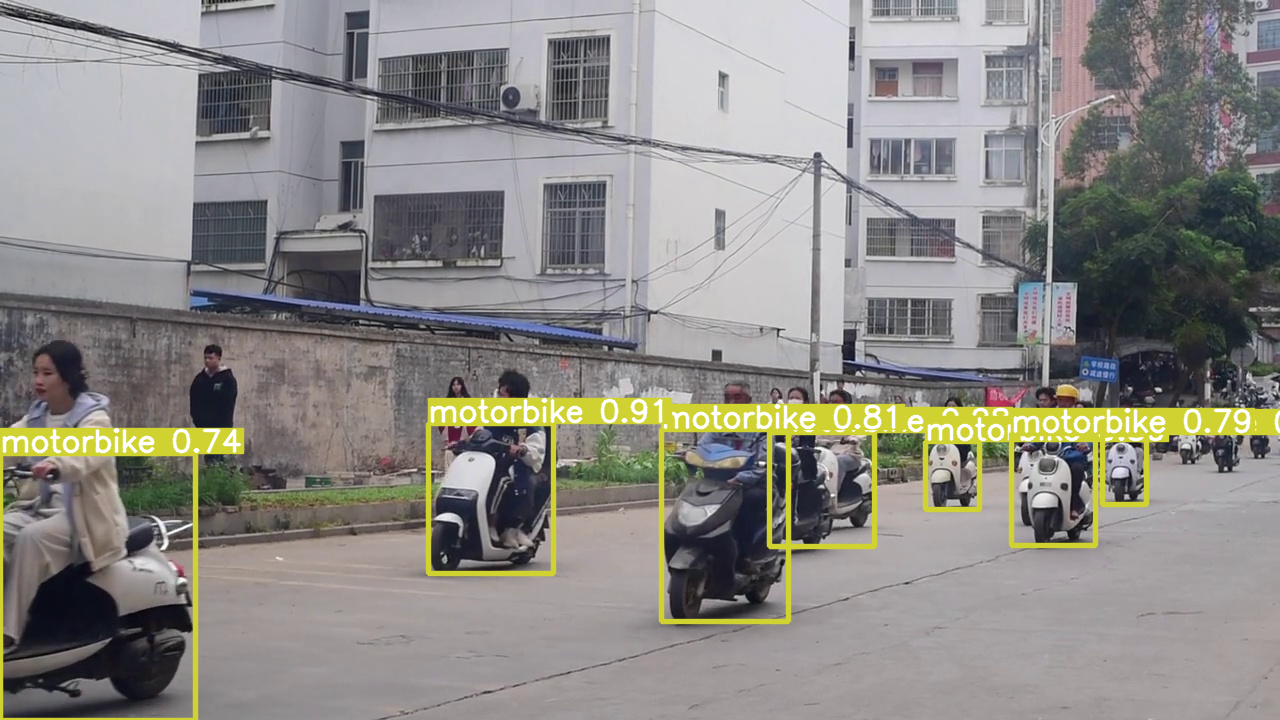

In [7]:
from PIL import Image
example_image_path = r"test_image_1.jpg"
res = model(example_image_path, device="cpu")
Image.fromarray(res[0].plot()[:, :, ::-1])

image 1/1 E:\Helmet-Compliance-Detection-System\test_image_1.jpg: 384x640 6 helmets, 7 persons, 53.7ms
Speed: 1.7ms preprocess, 53.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


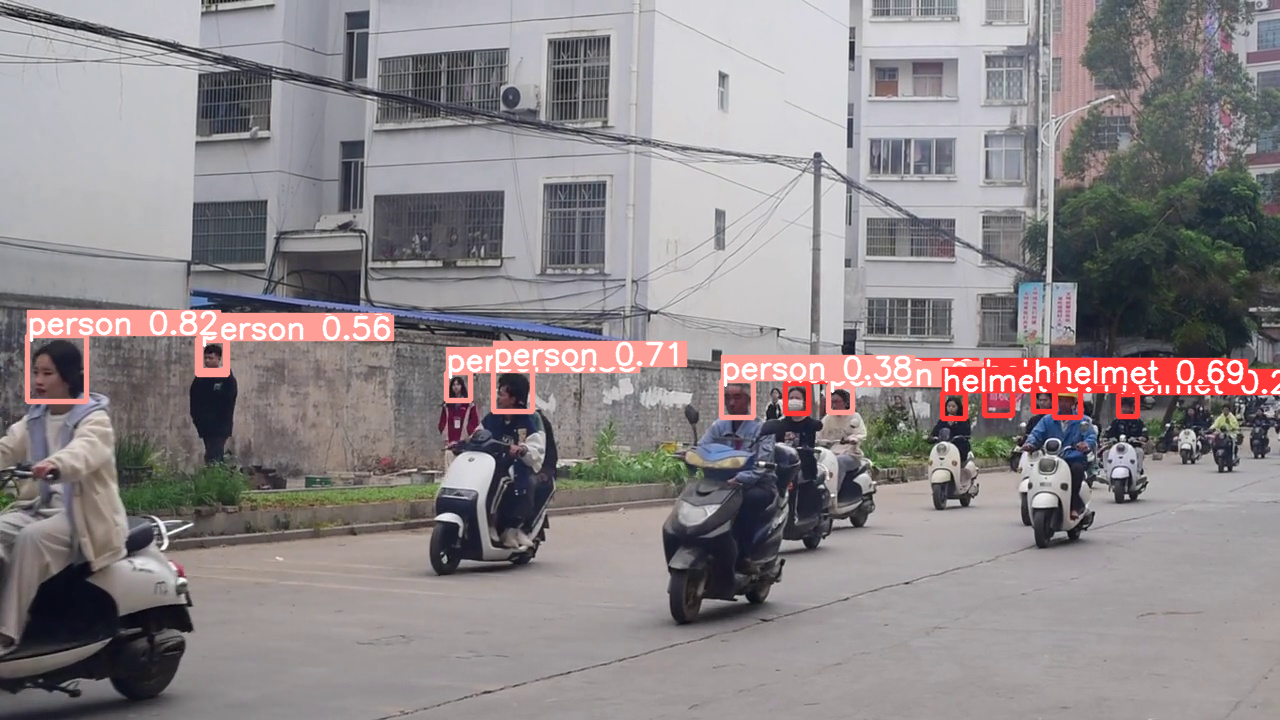

In [20]:
from PIL import Image
example_image_path = r"test_image_1.jpg"
res = model_helmet(example_image_path, device="cpu")
Image.fromarray(res[0].plot()[:, :, ::-1])

In [21]:
from pathlib import Path
OV_MODEL_PATH = Path(f"bicycle_weights/best_openvino_model/best.xml")
OV_MODEL_PATH_helmet = Path(f"runs/detect/train7/weights/best_openvino_model/best.xml")

In [22]:
import ipywidgets as widgets
import openvino as ov

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [23]:
ov_model = core.read_model(OV_MODEL_PATH)
ov_model_helmet = core.read_model(OV_MODEL_PATH_helmet)

ov_config = {}
if device.value != "CPU":
    ov_model.reshape({0: [1, 3, 1024, 1024]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

compiled_ov_model = core.compile_model(ov_model, device.value, ov_config)
compiled_ov_model_helmet = core.compile_model(ov_model_helmet, device.value, ov_config)

In [24]:
print(model.predictor)
print(model_helmet.predictor)


In [25]:
import torch


def infer(*args):
    result = compiled_ov_model(args)[0]
    return torch.from_numpy(result)


model.predictor.inference = infer

In [26]:
def infer(*args):
    result = compiled_ov_model_helmet(args)[0]
    return torch.from_numpy(result)


model_helmet.predictor.inference = infer

In [27]:
import time
import os
import cv2
# 获取图片路径列表
dataset_path = r"E:\Safety-Helmet-Wearing-Dataset\bicycle\merged_dataset\images\train"
test_images = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
length = len(test_images)
start = time.time()
# 测试图片集
# test_images = [r"test_image_1.jpg", r"test_image_2.png"]
# length = len(test_images)
results = model(test_images, device="cpu")  # return a list of Results objects

# 函数用于检测头盔, 并修改图片
def detect_helmet(cropped_image):
    # 假设model_helmet是已经加载的模型，并对输入的图像进行头盔检测
    result = model_helmet(cropped_image, device="cpu")
    boxes = result[0].boxes
    helmet_detections = []

    # 遍历每个检测到的边界框
    for i, bbox in enumerate(boxes.xyxy):
        x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])  # 从bbox提取坐标
        # 获取类别，这里假设cls为0表示佩戴了头盔
        if int(boxes.cls[i]) == 0:
            label = 'Helmet'
            color = (0, 255, 0)  # 绿色表示佩戴了头盔
            helmet_detections.append({
                'bbox': bbox.tolist(),  # 将tensor转换为list
                'label': 'helmet'       # 标记为佩戴头盔
            })
        else:
            label = 'No Helmet'
            color = (0, 0, 255)  # 红色表示未佩戴头盔
            helmet_detections.append({
                'bbox': bbox.tolist(),  # 将tensor转换为list
                'label': 'no helmet'    # 标记为未佩戴头盔
            })
        # 在图像上绘制边界框和标签
        cv2.rectangle(cropped_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(cropped_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return helmet_detections

# 用于存储最终结果
final_results = []

# Process results list
for i in range(length):
    original_image = cv2.imread(test_images[i])
    boxes = results[i].boxes  # Boxes object for bounding box outputs
    # print("boxes:", boxes)
    # print(boxes.cls)
    for t, bbox in enumerate(boxes.xyxy):
        if int(boxes.cls[t]) == 4: # 筛选cls为电瓶车的结果
            x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
            box_height = y2 - y1
            # 调整y1以包括等于框高度的上方区域
            y1 = max(0, y1 - box_height)  # 防止越界
            # 裁剪图像
            cropped_image = original_image[y1:y2, x1:x2]
            # 检测头盔
            helmet_detections = detect_helmet(cropped_image)
            # 保存结果
            final_results.append({
                'scooter_bbox': (x1, y1, x2, y2),
                'helmet_detections': helmet_detections
            })
    # cv2.imwrite(f'annotated_image_{i}.jpg', original_image)

# 计算FPS
end = time.time()
total_time = end - start
fps = length / total_time
print(f"FPS: {fps:.2f}")
print("总时长", total_time)

0: 640x640 1 car, 19.3ms
1: 640x640 2 cars, 19.3ms
2: 640x640 2 cars, 19.3ms
3: 640x640 1 car, 19.3ms
4: 640x640 1 car, 2 motorbikes, 19.3ms
5: 640x640 1 car, 1 motorbike, 19.3ms
6: 640x640 1 car, 1 motorbike, 19.3ms
7: 640x640 2 cars, 19.3ms
8: 640x640 1 car, 1 motorbike, 19.3ms
9: 640x640 2 cars, 19.3ms
10: 640x640 3 cars, 1 motorbike, 19.3ms
11: 640x640 1 car, 1 threewheel, 19.3ms
12: 640x640 2 cars, 19.3ms
13: 640x640 1 car, 19.3ms
14: 640x640 1 car, 19.3ms
15: 640x640 1 car, 1 motorbike, 19.3ms
16: 640x640 2 motorbikes, 19.3ms
17: 640x640 1 car, 1 motorbike, 19.3ms
18: 640x640 1 car, 2 motorbikes, 19.3ms
19: 640x640 2 cars, 1 motorbike, 19.3ms
20: 640x640 1 car, 1 motorbike, 19.3ms
21: 640x640 1 car, 1 motorbike, 19.3ms
22: 640x640 1 car, 1 motorbike, 19.3ms
23: 640x640 2 motorbikes, 19.3ms
24: 640x640 1 car, 1 motorbike, 19.3ms
25: 640x640 1 car, 2 motorbikes, 19.3ms
26: 640x640 3 motorbikes, 19.3ms
27: 640x640 2 cars, 1 motorbike, 19.3ms
28: 640x640 2 cars, 19.3ms
29: 640x640 1 